# Calcul de la consommation globale

On commence par charger les données, on les affiche, on les trie et on fait une première synthèse des consommation par moteur et par vol.

L'idées est de construire une table résumant les données de chaque vol et la consommation correspondate de chaque moteur.

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import tabata as tbt
from tabata import Opset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

## 1. Récupération et affichage des données.

On affiche les données de manière à mieux comprendre comment définir les phases de vol.
Pour simplifier les accès j'utilise l'Opset de tabata.

In [3]:
datadir = "../data/"
datafiles = glob(os.path.join(datadir,'*.h5'))

In [4]:
datafiles

['../data/Aircraft_01.h5', '../data/Aircraft_02.h5', '../data/Aircraft_03.h5']

In [5]:
sorting = lambda name: int(name[8:])
ds = Opset(datafiles[0], sortkey=sorting)
ds.plotc()

### Recherche d'un moyen d'identifier les phases de vol

Un affichage interactif avec des variables en parallèle de l'altitude.

In [6]:
os.path.basename(ds.storename)[:-3]

'Aircraft_01'

In [7]:
from ipywidgets import interact, widgets

def mydoubleplot(varname, record):
    df = ds[record]
    tbt.doubleplot(df[varname], df["ALT [ft]"], title=os.path.basename(ds.storename)[:-3]+f" Flight {record}")

interact(mydoubleplot, varname=ds.df.columns, record=widgets.IntSlider(0,0,len(ds)-1,1)) ; #range(len(ds))) ;

interactive(children=(Dropdown(description='varname', options=('ALT [ft]', 'EGT_1 [deg C]', 'EGT_2 [deg C]', '…

In [8]:
LB2KG = 0.453592  # kg/lb 
KDENS = 0.73      # kg/l
L = []
for file in datafiles:
    ac = 'AC'+file[-5:-3]
    ds = Opset(file,sortkey=sorting) # Ne pas oublier de trier les enregistrements.
    for i,df in enumerate(ds):
        if len(df.columns)>0 and "ALT [ft]" in df.columns:
            alt = df["ALT [ft]"]
            Alt_max = max(alt)
            if Alt_max > 20000:
                mc = df["M [Mach]"]
                # Il faudra peut-être séparer la montée et la descente de la croisière.
                df1 = df[mc>0.1]
                # Quand il faudra rajouter les phases au sol.
                #i0 = df1.index[0]
                #i1 = df1.index[-1]
                #taxi_o = df[:i0-1]
                #taxi_i = df[i1+1:]
                Leg = len(df1)/3600.0 # En h
                Q1 = df1["Q_1 [lb/h]"].sum()/3600.0 # en lb
                Q2 = df1["Q_2 [lb/h]"].sum()/3600.0
                M1 = Q1*LB2KG # En kg
                M2 = Q2*LB2KG
                Masse = M1+M2
                C1 = M1/KDENS # En l
                C2 = M2/KDENS
                Mach_max = df1["M [Mach]"].max()
                L += [[ac, 'Left', i, Leg, Alt_max, Mach_max, Masse, C1]]
                L += [[ac, 'Right', i, Leg, Alt_max, Mach_max, Masse, C2]]
dft = pd.DataFrame(L,columns = ['AC', 'ENG', 'Flight', 'Leg', 'Alt_max', 'Mach_max', 'Masse', 'Conso'])

In [9]:
dft

,AC,ENG,Flight,Leg,Alt_max,Mach_max,Masse,Conso
0,AC01,Left,0,1.619722,39439.264501,0.640898,3725.812542,2547.848842
1,AC01,Right,0,1.619722,39439.264501,0.640898,3725.812542,2556.003956
2,AC01,Left,1,1.698056,39457.811063,0.649114,3873.297269,2652.136497
3,AC01,Right,1,1.698056,39457.811063,0.649114,3873.297269,2653.750172
4,AC01,Left,2,1.548889,40825.620025,0.624464,3395.975242,2326.615381
...,...,...,...,...,...,...,...,...
5989,AC03,Right,999,1.132222,37621.701406,0.591598,2481.130405,1724.592070
5990,AC03,Left,1000,1.423889,36471.814551,0.632681,2990.838764,2019.218569
5991,AC03,Right,1000,1.423889,36471.814551,0.632681,2990.838764,2077.820834
5992,AC03,Left,1001,1.110278,37134.854149,0.599814,2425.202981,1639.174987


### Affichage de la consommation en fonction de la durée du vol.

On présente une relation entre durée du vol et consommation.
La variance résiduelle peut eut-être être encore réduite en travaillant sur la montée et la descente séparemment de la croisière.

In [10]:
import plotly.express as px

In [11]:
fig = px.scatter(dft, x="Leg", y="Conso", color="AC", symbol="ENG", 
           hover_data=dict(AC=True, ENG=True, Flight=True, Leg=False, Conso=False), 
           opacity=0.4,
           title="Consommation en fonction de la durée de vol",
           labels={"Conso" : "Consommation (litres)", "Leg" : "Durée du vol (heures)"})
fig.update_traces(marker=dict(size=12))

Cette figure présente le calcul de la consommation en fonction de la durée des vols. Les avions sont représentés par des couleurs différentes, le moteur gauche est un point rond et le droit un losange. Cet affichage est interactif, en zoomant sur une durée particulière on se rend compte d'une variance importante.

In [12]:
# On focalise sur une durée particulière.
fig = px.scatter(dft, x="Leg", y="Conso", color="AC", symbol="ENG", 
           hover_data=dict(AC=True, ENG=True, Flight=True, Leg=False, Conso=False), 
           opacity=0.4,
           title="Consommation en fonction de la durée de vol",
           labels={"Conso" : "Consommation (litres)", "Leg" : "Durée du vol (heures)"})
fig.update_traces(marker=dict(size=12))
fig.update_layout(xaxis_range=[1.96,2.1], yaxis_range=[2400, 3500])

Notons que sur cette image nous observons un écart de plus de 1000 litres de carburant pour une durée d'environ 2h de vol.

### Calcul de la précision relative.

Le plus simple est de prendre l'écart-type de l'erreur d'estimation divisée par la moyenne de la consommation pour commencer.

In [13]:
model = smf.ols("Conso ~ Leg", data=dft)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Conso   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 3.305e+05
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:15:13   Log-Likelihood:                -36216.
No. Observations:                5994   AIC:                         7.244e+04
Df Residuals:                    5992   BIC:                         7.245e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    126.0679      4.188     30.104      0.0

In [14]:
x = dft['Leg']
y = dft['Conso'].values
hy = res.predict()
100*2*1.96*(np.std(hy-y))/np.mean(y)

16.54999075647463

In [15]:
dy = hy-y
(100*np.diff(np.percentile(dy,[2.5, 97.5]))/np.mean(y)).item()

17.214645009545183

In [16]:
# Je vote pour ce calcul simple.
r = dy/y
(100*np.diff(np.percentile(r,[2.5, 97.5]))).item()

16.84651419079862

In [17]:
2*1.96*100*np.std(r)

17.11162394430647

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   2.,   1.,   3.,   3.,   9.,  13.,  30.,  56., 102., 156.,
        217., 282., 393., 440., 543., 504., 512., 473., 393., 403., 315.,
        271., 180., 131., 110.,  87.,  74.,  56.,  36.,  41.,  31.,  21.,
          8.,  19.,  13.,  11.,  10.,   6.,   3.,   6.,   6.,   0.,   2.,
          2.,   1.,   1.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([-0.30949784, -0.30172437, -0.2939509 , -0.28617742, -0.27840395,
        -0.27063047, -0.262857  , -0.25508352, -0.24731005, -0.23953657,
        -0.2317631 , -0.22398962, -0.21621615, -0.20844267, -0.2006692 ,
        -0.19289572, -0.18512225, -0.17734877, -0.1695753 , -0.16180182,
        -0.15402835, -0.14

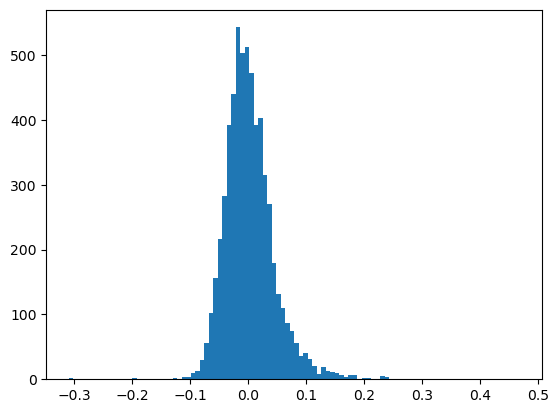

In [18]:
plt.hist(r, bins=100)

Cette information ne refète pas la variabilité locale autour d'une consommation spécifique.
On regarde une enveloppe de voisinage des points par consommation.

In [19]:
w = 100 #(précision de 100l)
up = np.zeros(len(y))
dn = np.zeros(len(y))
st = np.zeros(len(y))
dy = hy-y
for i, yy in enumerate(y):
    j = np.argwhere(np.abs(y-yy)<=w)
    st[i] = np.std(dy[j])
    dn[i], up[i] = np.percentile(dy[j],[2.5, 97.5])
    #up[i] = np.max(dy[j])
    #dn[i] = np.min(dy[j])


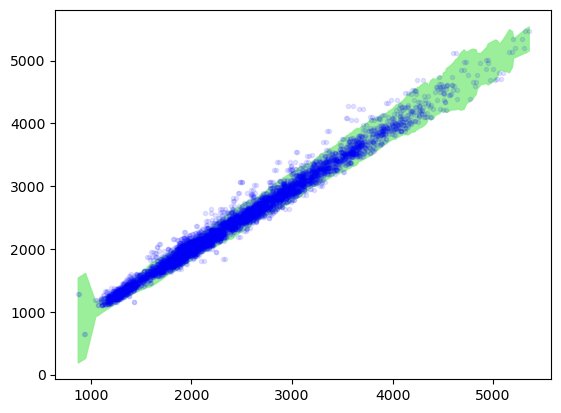

In [20]:
i = np.argsort(y)
plt.fill_between(y[i], y[i]+1.96*st[i], y[i]-1.96*st[i], color='lightgreen', alpha=0.9)
plt.plot(y[i],hy[i],'b.', alpha=0.1)
#plt.plot(y[i], y[i]+1.96*st[i])
#plt.plot(y[i], y[i]-1.96*st[i])

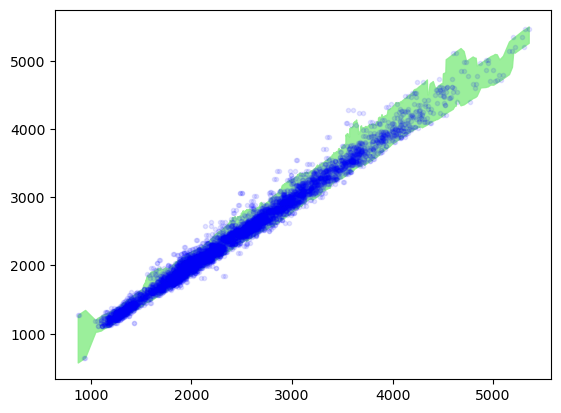

In [21]:
plt.fill_between(y[i], y[i]+up[i], y[i]+dn[i], color='lightgreen', alpha=0.9)
plt.plot(y[i],hy[i],'b.', alpha=0.1)
#plt.plot(y[i], y[i]+up[i])
#plt.plot(y[i], y[i]+dn[i])

In [22]:
imax = np.argmax(up-dn)
print(f"Imprecision maximale de {up[imax]-dn[imax]:.0f}l sur une consommation de {y[imax]:.0f}l")
print(f"    soit {100*(up[imax]-dn[imax])/y[imax]:.0f}%.")

r = (up-dn)/y
imax = np.argmax(r)
print(f"Imprécision relative maximale de {up[imax]-dn[imax]:.0f}l sur une consommation de {y[imax]:.0f}l")
print(f"    soit {100*r[imax]:.0f}%.")

dmean = np.mean(up-dn)
ymean = np.mean(y)
print(f"Imprécision moyenne de {dmean:.0f}l sur une consommation moyenne de {ymean:.0f}l")
print(f"    soit {100*dmean/ymean:.0f}%.")

rmean = np.mean((up-dn)/y)
print(f"Imprécision relative moyenne de {rmean*ymean:.0f}l sur une consommation moyenne de {ymean:.0f}l")
print(f"    soit {100*rmean:.0f}%.")

print()
print(f"Calculs effectués à {w} litres près.")

Imprecision maximale de 838l sur une consommation de 4676l
    soit 18%.
Imprécision relative maximale de 697l sur une consommation de 869l
    soit 80%.
Imprécision moyenne de 382l sur une consommation moyenne de 2412l
    soit 16%.
Imprécision relative moyenne de 394l sur une consommation moyenne de 2412l
    soit 16%.

Calculs effectués à 100 litres près.


#### En conclusion.

Statistiquement à 95% près :

In [23]:
# Je vote pour ce calcul simple.
r = dy/y
q = (100*np.diff(np.percentile(r,[2.5, 97.5]))).item()
print(f"On observe {q:.0f}% d'écart de consommation.")

On observe 17% d'écart de consommation.


Pour une estimation large à 100 litres près :

In [24]:
print(f"Imprécision relative moyenne de {rmean*ymean:.0f}l sur une consommation moyenne de {ymean:.0f}l soit {100*rmean:.0f}%.")

Imprécision relative moyenne de 394l sur une consommation moyenne de 2412l soit 16%.


## 2. Analyse séparée de chaque phase de vol.

Une fonction écrite par Dinh permet de récupérer chacune de s phases de vols indépendamment.
Pour illustrer cette fonction nous allors créer un nouveau Opset qui contiendra les phases de vols stockées sous forme de colonnes booléennes.

J'ai créé un fichier `__init__.py` pour pouvoir facilement importer les éléments de codes sans faire d'import local.

In [25]:
from utils import detect_phase, get_consumption
detect_phase

<function utils.detect_phase(df, threshold)>

In [26]:
# Rappel : ds contient les vols du premier avion.
ds.rewind()
altitude_threshold = 0.95 # (0.95) Valeur par défaut fixée par Dinh.
storename = os.path.basename(ds.storename)
newstore = os.path.join(datadir,'out',storename[:-3]+'_phases.h5')
ds2 = Opset(newstore).clean()

# Je reprend le début du code de la fonction get_consumption...
for i, df in enumerate(ds):

        if len(df.columns)>0 and "ALT [ft]" in df.columns:
            
            alt = df["ALT [ft]"]
            Alt_max = max(alt)

            if Alt_max > 20000:
                
                ## selecting phase index
                phases = detect_phase(df, altitude_threshold) # phases = taxi1_idx, climb_idx, cruise_idx, descend_idx, taxi2_idx

                if phases == False:
                    print(i)
                    continue
                else:
                    taxi1_idx, climb_idx, cruise_idx, descend_idx, taxi2_idx = phases
                    df['TAXI1'] = (df.index>=taxi1_idx[0]) & (df.index<taxi1_idx[1])
                    df['CLIMB'] = (df.index>=climb_idx[0]) & (df.index<climb_idx[1])
                    df['CRUISE'] = (df.index>=cruise_idx[0]) & (df.index<cruise_idx[1])
                    df['DESCEND'] = (df.index>=descend_idx[0]) & (df.index<descend_idx[1])
                    df['TAXI2'] = (df.index>=taxi2_idx[0]) & (df.index<taxi2_idx[1])
                    ds2.put(df)

Record is incomplete
560


In [27]:
dsp = Opset("../data/out/Aircraft_03_phases.h5")

In [28]:
dsp.rewind().plotc("CLIMB")

In [29]:
ds.rewind()
dfpc = get_consumption(ds, 'climb')

Record is incomplete
560


In [30]:
dfpc

,AC,ENG,Flight,Duration,Alt_max,Alt_slope,Avg_egt,TAT_max,TAT_min,T_oil_range,M_max,Volume,Weight
0,../data/Aircraft_03.h5,Left,0,0.359167,42003.326724,0.640898,30.889421,1527.673543,40.273509,-33.516209,20.268821,965.131621,1408.508188
1,../data/Aircraft_03.h5,Right,0,0.359167,42003.326724,0.640898,30.889421,1527.673543,40.273509,-33.516209,20.802211,964.331650,1408.508188
2,../data/Aircraft_03.h5,Left,1,0.265278,40603.061279,0.640898,40.035328,1561.108094,46.760517,-31.083580,18.668651,791.007047,1153.861696
3,../data/Aircraft_03.h5,Right,1,0.265278,40603.061279,0.640898,40.035328,1561.108094,46.760517,-31.083580,19.735431,789.625414,1153.861696
4,../data/Aircraft_03.h5,Left,2,0.269444,41790.041259,0.640898,40.926718,1571.678902,27.299492,-34.327085,21.335601,805.720536,1172.544658
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,../data/Aircraft_03.h5,Right,999,0.230278,37621.701406,0.591598,43.155993,1507.118239,14.325476,-32.164749,21.335601,708.624965,1021.854066
1994,../data/Aircraft_03.h5,Left,1000,0.234722,36471.814551,0.632681,40.127518,1518.699248,14.866060,-25.677740,26.669501,711.323933,1051.478719
1995,../data/Aircraft_03.h5,Right,1000,0.234722,36471.814551,0.632681,40.127518,1518.699248,14.866060,-25.677740,26.669501,729.057874,1051.478719
1996,../data/Aircraft_03.h5,Left,1001,0.253333,37134.854149,0.599814,38.720016,1452.564740,12.433432,-32.705333,21.868991,729.032455,1074.363055


In [32]:
# Regression.
model = smf.ols("Volume ~ Duration + Alt_max + M_max", data=dfpc)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 2.005e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:17:01   Log-Likelihood:                -9482.7
No. Observations:                1998   AIC:                         1.897e+04
Df Residuals:                    1994   BIC:                         1.900e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.9922     11.476      5.140      0.0

In [36]:
dfpc["Prediction"] = res.predict()
fig = px.scatter(dfpc, x="Prediction", y="Volume", color="AC", symbol="ENG", 
           hover_data=dict(AC=True, ENG=True, Flight=True, Duration=False, Volume=False, Alt_max=False, M_max=False), 
           opacity=0.4,
           title="Consommation durant la montée",
           labels={"Consumption" : "Consommation (litres)", "Prediction" : "Estimation de la consommation"})
fig.update_traces(marker=dict(size=12))

In [37]:
ds2 = Opset(datafiles[0], sortkey=sorting)


In [38]:
dfpc2 = get_consumption(ds2, 'climb')

Record is incomplete
438


In [39]:
y = res.predict(dfpc2)
dfpc2["Prediction"] = y
fig = px.scatter(dfpc2, x="Prediction", y="Volume", color="AC", symbol="ENG", 
           hover_data=dict(AC=True, ENG=True, Flight=True, Duration=True, Volume=False, Alt_max=False, M_max=False), 
           opacity=0.4,
           title="Consommation durant la montée",
           labels={"Consumption" : "Consommation (litres)", "Prediction" : "Estimation de la consommation"})
fig.update_traces(marker=dict(size=12))
fig.show()
print(f"Consommation durant la montée de {ds2.storename} à partir du modèle de {ds.storename}")


Consommation durant la montée de ../data/Aircraft_01.h5 à partir du modèle de ../data/Aircraft_03.h5


**Pour les étapes suivantes**

1. Faire un test statistique validant ce modèle.
2. Les résidus sont-ils gaussiens ?
3. Estimer les résidus et la variance globale.
4. Cette variance dépend elle de la durée du vol.
5. Améliorer l'estimation en rajoutant des facteurs ?
6. Montrer quels facteurs sont pertinents.
7. A-t-on des dépendances temporelles résiduelles ?